In [65]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
import math

Optimal Parameters:
a=0.1290, b=0.0591, sigma=0.0470, r0=0.0343


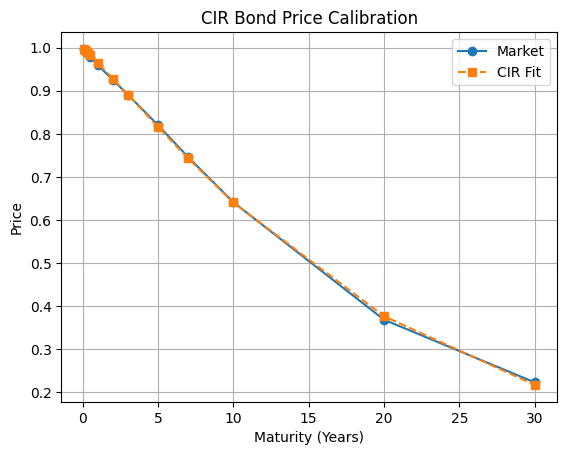

RMSE: 0.003847


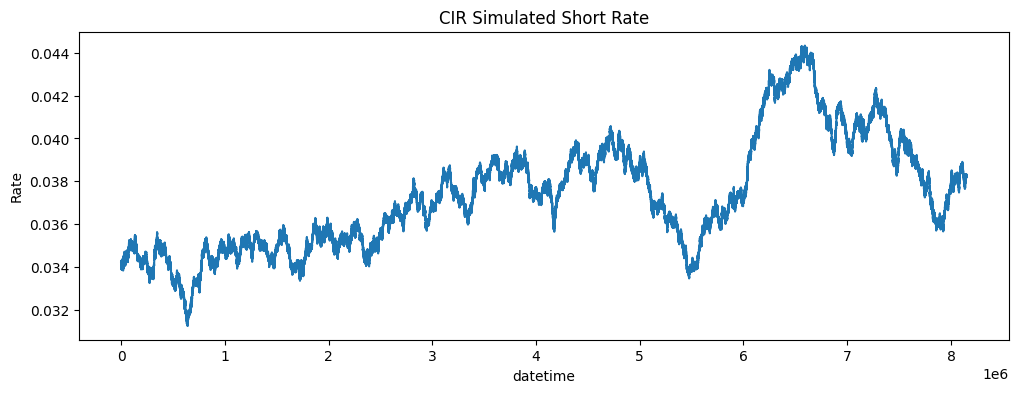

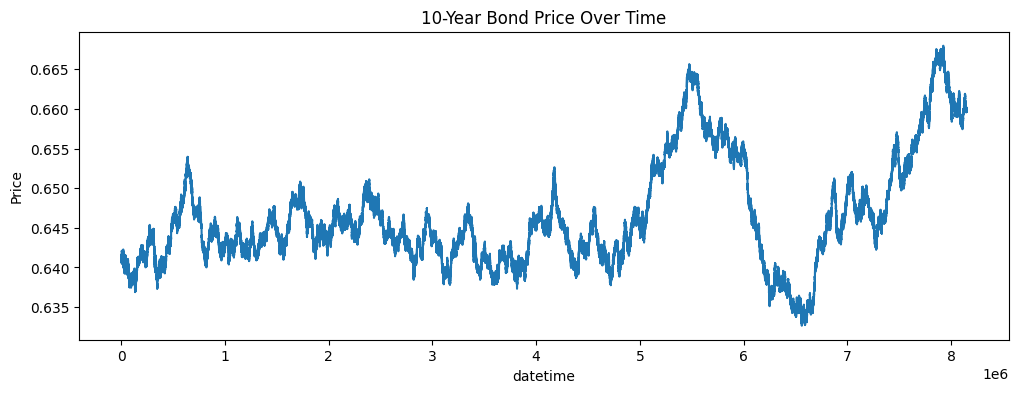

In [50]:
%run Simulated_bond_data.ipynb

In [51]:
price_book = pd.read_csv("Data/simulated_bond_market_data.csv")
price_book['spread'] = price_book['ask_price'] - price_book['bid_price']

In [52]:
len(price_book)

8149680

In [66]:
def estimate_k_and_A(window_df):
    window_df = window_df.copy()
    window_df['spread_bin'] = pd.cut(window_df['spread'], bins=np.arange(0, 0.1, 0.0025))
    volume_by_bin = window_df.groupby('spread_bin', observed=True)['volume'].sum().reset_index()
    volume_by_bin = volume_by_bin[volume_by_bin['volume'] > 0]
    volume_by_bin['bin_mid'] = volume_by_bin['spread_bin'].apply(lambda x: x.mid)

    X = volume_by_bin['bin_mid'].values
    y = np.log(volume_by_bin['volume'].values)

    if len(X) < 2:
        return 50, 1

    slope, intercept = np.polyfit(X, y, deg=1)
    k = max(1e-3, abs(slope))
    A = max(1e-3, np.exp(intercept))
    return k, A / 1200 


In [54]:
def estimate_liquidity_curves(window):
    """
    Estimate A and k separately for bid and ask sides over a given window.

    Returns:
        k_bid, A_bid, k_ask, A_ask
    """
    # Bid-side
    bid_window = window[['mid_price', 'bid_price', 'vol_bid']].copy()
    bid_window['spread'] = bid_window['mid_price'] - bid_window['bid_price']
    bid_window = bid_window.rename(columns={'vol_bid': 'volume'})
    k_bid, A_bid = estimate_k_and_A(bid_window)

    # Ask-side
    ask_window = window[['ask_price', 'mid_price', 'vol_ask']].copy()
    ask_window['spread'] = ask_window['ask_price'] - ask_window['mid_price']
    ask_window = ask_window.rename(columns={'vol_ask': 'volume'})
    k_ask, A_ask = estimate_k_and_A(ask_window)

    return k_bid, A_bid, k_ask, A_ask


In [ ]:
def set_bid_ask_prices(mid, inventory, base_spread=0.005, gamma=0.003):
    """
    Set bid/ask prices with realistic spread and inventory skewing.
    """
    skew = gamma * math.log(abs(inventory) + 1)
    if inventory > 0:
        bid = mid - (base_spread / 2) - skew
        ask = mid + (base_spread / 2) - skew
    else:
        bid = mid - (base_spread / 2) + skew
        ask = mid + (base_spread / 2) + skew
    
    bid = min(mid - 1e-6, bid)
    ask = max(mid + 1e-6, ask)

    return bid, ask


In [68]:
def generate_num_trades(A_bid, k_bid, dist_to_bid, A_ask, k_ask, dist_to_ask):
    """
    Generate the number of trades based on the distance to bid and ask prices
    """    
    lambda_t_bid = A_bid * np.exp(-k_bid * dist_to_bid) if A_bid is not None else 0
    lambda_t_ask = A_ask * np.exp(-k_ask * dist_to_ask) if A_ask is not None else 0
    num_trades_bid = np.random.poisson(lam=lambda_t_bid)
    num_trades_ask = np.random.poisson(lam=lambda_t_ask)
    return num_trades_bid, num_trades_ask

In [57]:
def is_toxic(delta, sensitivity = 340):
    return 1 / (1 + np.exp(-sensitivity * (delta - 0.01)))

In [58]:
base_spread = .005
gamma = 0.1

In [71]:
inventory = 0
cash = 0
toxic = 0
toxic_pnl = []
book = []
trades = []
volume = []
bids = []
asks = []
mids = []
net_value = []

for index in tqdm(range(1201, len(price_book) - 600)):
    # Group spread and volume count to estimate liquidity
    if index % 1201 == 0:
        window = price_book.loc[index - 1200 : index - 1]
        k_bid, A_bid, k_ask, A_ask = estimate_liquidity_curves(window)

    # Set bid/ask
    mid = price_book.loc[index - 1, 'mid_price']
    bid, ask = set_bid_ask_prices(mid, inventory)

    bids.append(bid)
    asks.append(ask)
    mids.append(mid)

    # Calculate number of trades
    dist_to_bid = abs(mid - bid)
    dist_to_ask = abs(ask - mid)

    num_trades_bid, num_trades_ask = generate_num_trades(A_bid, k_bid, dist_to_bid, A_ask, k_ask, dist_to_ask)

    bid_toxic_p = is_toxic(dist_to_bid)
    ask_toxic_p = is_toxic(dist_to_ask)

    future_price = price_book.loc[index + 600, 'mid_price']
    net_value.append(cash + inventory * mid)
    
    for _ in range(num_trades_bid):
        if np.random.rand() < bid_toxic_p:
            if future_price < mid:
                inventory += 1
                cash -= bid
                toxic_tick += future_price - bid
            else:
                continue
        else:
            inventory += 1
            cash -= bid
    toxic_tick = 0
    for _ in range(num_trades_ask):
        if np.random.rand() < ask_toxic_p:
            if future_price > mid:
                inventory -= 1
                cash += ask
                toxic_tick += ask - future_price
            else:
                continue
        else:
            inventory -= 1
            cash += ask

    volume.append(num_trades_bid + num_trades_ask)
    trades.append(inventory)
    book.append(cash)
    toxic_pnl.append(toxic_tick)
    


100%|██████████| 8147879/8147879 [03:06<00:00, 43679.08it/s]


In [72]:

cash_df = pd.DataFrame({
    'cash': book,
    'inventory': trades,
    'volume': volume,
    'toxic_pnl': toxic_pnl,
    'bids': bids,
    'asks': asks,
    'mids': mids,
    'net_value': net_value
})


# Simulate timestamps assuming 1-second intervals
cash_df['timestamp'] = pd.date_range(start='2025-07-03 08:00:00', periods=len(book), freq='s')
cash_df.set_index('timestamp', inplace=True)

cash_df.to_csv('Data/simulated_bond_market_making.csv')
